In [20]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/Data Analysis')
print(os.listdir(os.getcwd()))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['data', 'Top 20 Businesses Frequented by VIPs.png', 'Data Preprocessing.ipynb', 'business categories with most reviews from vips.ipynb', 'predict rating (1).ipynb', 'processed_attributes_round8.csv', 'processed_attributes_round13.csv', 'business.json', 'predict rating.ipynb', 'x_round8.csv', 'y_round8.csv', 'bydegree.gephi (Unzipped Files)', 'Q1', 'Q2', ' Q3 regression', 'Q4 Predictive model', 'Q5  Network', 'Untitled0.ipynb', 'feature importance for restaurant.png', 'feature importance for bs.png', 'Restaurants attract users with lots of fans.ipynb', ' Q4 Predictive model']


In [0]:
import pandas as pd
import numpy as np
import json
import gc
from tqdm import tqdm_notebook as tqdm
import operator
import matplotlib.pyplot as plt

In [0]:
pd.set_option('display.max_columns', 100)
gc.enable()

In [0]:
user = pd.read_csv('data/round8/csv/user.csv', low_memory=False)
business = pd.read_csv('data/round8/csv/business.csv', low_memory=False)
review = pd.read_csv('data/round8/csv/review.csv', low_memory=False)

## 输出在Arizona的存在business_id的business的id

In [0]:
business = pd.read_csv('data/round8/csv/business.csv', low_memory=False)
business_az = business[business['state'].astype(str).str.contains('AZ')]
business_az = business_az[business_az['business_id'].astype(str).str.len() > 0]
business_az_id = business_az['business_id'].tolist()

## 找出给Arizona的business做过评论的人，因为他们可能住在Arizona

In [0]:
busi_user_tuple = review[["business_id", "user_id"]]
busi_to_user_dict = dict(busi_user_tuple.set_index('business_id').groupby(level = 0).\
    apply(lambda x : x.to_dict(orient= 'records')))

In [0]:
user_review_az = set()
for business in tqdm(business_az_id):
  try:
    for i in range(len(busi_to_user_dict[business])):
      user_review_az.add(busi_to_user_dict[business][i]['user_id'])
  except KeyError:
    pass

## 统计上面这些user做过评论的business地域，如果占最多的是AZ，那就可以假设他住在AZ

In [0]:
user_to_busi_dict = dict(busi_user_tuple.set_index('user_id').groupby(level = 0).\
    apply(lambda x : x.to_dict(orient= 'records')))

In [0]:
business = pd.read_csv('data/round8/csv/business.csv', low_memory=False)
busi_state_tuple = business[["business_id", "state"]]
busi_state_dict = busi_state_tuple.set_index("business_id").T.to_dict("list")

In [0]:
busi_state_dict

In [0]:
user_to_state_dict = {}
for user in tqdm(user_review_az):
  try:
    for i in range(len(user_to_busi_dict[user])):
      if user in user_to_state_dict:
        user_to_state_dict[user].append(busi_state_dict[user_to_busi_dict[user][i]['business_id']][0])
      else:
        user_to_state_dict[user] = [busi_state_dict[user_to_busi_dict[user][i]['business_id']][0]]
  except KeyError:
    pass

In [0]:
user_to_state_dict

In [0]:
from collections import Counter

user_livein_az = set()

for k, v in tqdm(user_to_state_dict.items()):
  if Counter(v).most_common(1)[0][0] == "AZ":
    user_livein_az.add(k)

In [0]:
len(user_livein_az)

236438

## 判断这些住在AZ的user的friends是否也都住在AZ，删除掉那些不在AZ的，留下住在AZ的，建立network

In [0]:
user = pd.read_csv('data/round8/csv/user.csv', low_memory=False)
user_friends_tuple = user[["user_id", "friends"]]
user_friends_dict = user_friends_tuple.set_index("user_id").T.to_dict("list")

In [0]:
import re
user_az_friends_dict = {}
for user in user_livein_az:
  user_az_friends_dict[user] = re.findall(r"'(.*?)'", user_friends_dict[user][0])

In [0]:
remove = []
for k, v in tqdm(user_az_friends_dict.items()):
  if len(v) == 0:
    remove.append(k)
    
for k in remove: 
  del user_az_friends_dict[k]

### 生成用户本人住在AZ并且他的friends也在AZ的字典

In [0]:
user_az_friends_az_dict = {}
for k, v in tqdm(user_az_friends_dict.items()):
  for friend in v:
    if friend in user_livein_az:
      if k in user_az_friends_az_dict:
        user_az_friends_az_dict[k].append(friend)
      else:
        user_az_friends_az_dict[k] = [friend]

In [0]:
len(user_az_friends_az_dict)

82787

In [0]:
user_az_friends_az_dict

{'hTJfNIzJELCjnJtSaxzNPA': ['OzrWArrNWbCZfPjBxIiikA',
  'AIhYDORYfQCaCcKfVoAwmg',
  'rnLNRTurDeaZF3966-SDug'],
 'Vtey4fTvKn5SsZ0SZ0m62A': ['x_Hz1T8X360hDpoqt1bARA'],
 'fS884v0YIMhyN84ielcULg': ['P0yi8YGyGsge6RzL5qI1xA'],
 'bYnR1AUYpFRQOaFVW6AwRg': ['Yk37VAp452K7FwHWd1rrQw',
  'e2jlDTohcvd9WXV8Ix8wZw',
  '2HmPMHo_h6dcrMv2C7fYNQ',
  'g-9EwzkvBllXGUy0T3aB7Q',
  'lcMGFAhRU8QWdKyLZplcXQ',
  'vpF6S6q_1ZbghauBavRc8g'],
 '2BFk6id3Rp_7SGcR7hrgZA': ['D2NKLp8yrK-49RKslrOnpw',
  'wEmcIaytN99k-hf1WL6XNQ',
  '1khRm5iyfbDu2D4lpQbOcA',
  'TnJkGewuDhD0Dr6e5f58lQ',
  's7VkS-d1fheX5nNyPrEQPw',
  'P2ykPq0DkTil8vAifqcDBg',
  '1ilmuWkVxYIb4rUjfxQ-Uw',
  'Uhw_wKIajsPxVath7Kodlg',
  '_g-M8Y4pRhWWM4wynO2EUA',
  '0MvYHqnThbMa3gYjF_4pag',
  'NmMhhVIirN-RW8xrAg6dVA',
  '6rkICkKa9RlOMy-L8g05fw',
  'yrCVGo9hsKGUS1h2KpgUVw',
  '28nsy0LMP9C7K_4bnuSpDw',
  'xpci6ssX4TPIUJf-c75_Yg',
  'qoH9x2xoAP_8EEsxo0n9PQ',
  'THneaiQiebI4v3vq34h3dw',
  'RXXzv9LskM-Tu_h1w0eYYQ',
  'TjZhQBLKayZRxq6-Blt9HA',
  'k2lq_tjxNWLQt_hQSoS7Hw'

In [0]:
friends_dict = {}
for k, v in user_az_friends_az_dict.items():
  friends_dict[k] = len(v)

NameError: ignored

In [0]:
friends_dict

In [0]:
dict_sort_by_value = sorted(friends_dict.items(), key=lambda x:x[1], reverse=True)

In [0]:
fan_num = [x[1] for x in dict_sort_by_value]

In [0]:
fan_num

In [0]:
busi_user_tuple = review[["business_id", "user_id"]]

In [0]:
busi_user_tuple = busi_user_tuple.values.tolist()

In [0]:
top_1000_user = [top_1000_user[0] for top_1000_user in dict_sort_by_value[0:1000]]

In [0]:
user_busi_dict = {}
for user_id in tqdm(top_1000_user):
  for i in range(len(busi_user_tuple)):
    if busi_user_tuple[i][1] == user_id:
      if user_id in user_busi_dict:
        user_busi_dict[user_id].append(busi_user_tuple[i][0])
      else:
        user_busi_dict[user_id] = [busi_user_tuple[i][0]]

In [0]:
busi_for_V = set()
for k, v in user_busi_dict.items():
  busi_for_V.update(v)

In [0]:
busi_attract_count = {} 
for business in tqdm(busi_for_V):
  count = 0
  for k, v in user_busi_dict.items():
    if business in v:
      count += 1
  busi_attract_count[business] = count

In [0]:
len(busi_attract_count)

19503

In [0]:
#replace the business id to the business category
from pandas import DataFrame
new=DataFrame()

In [0]:
business = pd.read_csv('data/round8/csv/business.csv', low_memory=False)
business_az = business[business['state'].astype(str).str.contains('AZ')]
business_az = business_az[business_az['business_id'].astype(str).str.len() > 0]

In [0]:
new['business_id']=busi_attract_count.keys()

In [0]:
new['review_count_by_VIP']=busi_attract_count.values()

In [0]:
len(new)

19503

In [0]:
new1=pd.merge(new,business_az, on='business_id')

In [0]:
new1.to_csv('Q2/business with review count by vips.csv')

In [0]:
new1 = pd.read_csv('Q2/business with review count by vips.csv')

In [0]:
business_cats=['Restaurants','Shopping','Home Services','Nightlife','Health & Medical','Beauty & Spas','Bars','Local Services','Event Planning & Services','Active Life','Automotive']


In [0]:
cat_review=[]
for i in business_cats:
  a=new1[new1['categories'].str.contains(i)]
  b=sum(a['review_count_by_VIP'])
  cat_review.append(b)

In [0]:
review_all=[]
for i in business_cats:
  a1=new1[new1['categories'].str.contains(i)]
#   b1=sum(a1['review_count'])
  b1 = len(a1)
  review_all.append(b1)


In [26]:
len(a1)

948

In [0]:
catre=pd.DataFrame(columns=['category','review_count_by_VIP','amount','review_count_by_VIP%'])

In [0]:
catre['category']=business_cats
catre['review_count_by_VIP']=cat_review
catre['amount']=review_all
catre['review_count_by_VIP%']=catre['review_count_by_VIP']/catre['amount']

In [0]:
catre

,category,review_count_by_VIP,amount,review_count_by_VIP%
0,Restaurants,46972,6880,6.827326
1,Shopping,7447,2741,2.716892
2,Home Services,1013,664,1.525602
3,Nightlife,12073,1272,9.491352
4,Health & Medical,1319,866,1.523095
5,Beauty & Spas,2559,1242,2.060386
6,Bars,13831,1501,9.214524
7,Local Services,1254,672,1.866071
8,Event Planning & Services,1615,412,3.919903
9,Active Life,2866,802,3.573566


In [0]:
catre=catre.sort_values(by='review_count_by_VIP%',ascending=False)

In [0]:
catre.index = range(len(catre))


In [31]:
catre

,category,review_count_by_VIP,amount,review_count_by_VIP%
0,Nightlife,12073,1272,9.491352
1,Bars,13831,1501,9.214524
2,Restaurants,46972,6880,6.827326
3,Event Planning & Services,1615,412,3.919903
4,Active Life,2866,802,3.573566
5,Shopping,7447,2741,2.716892
6,Beauty & Spas,2559,1242,2.060386
7,Automotive,1863,948,1.965190
8,Local Services,1254,672,1.866071
9,Home Services,1013,664,1.525602


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


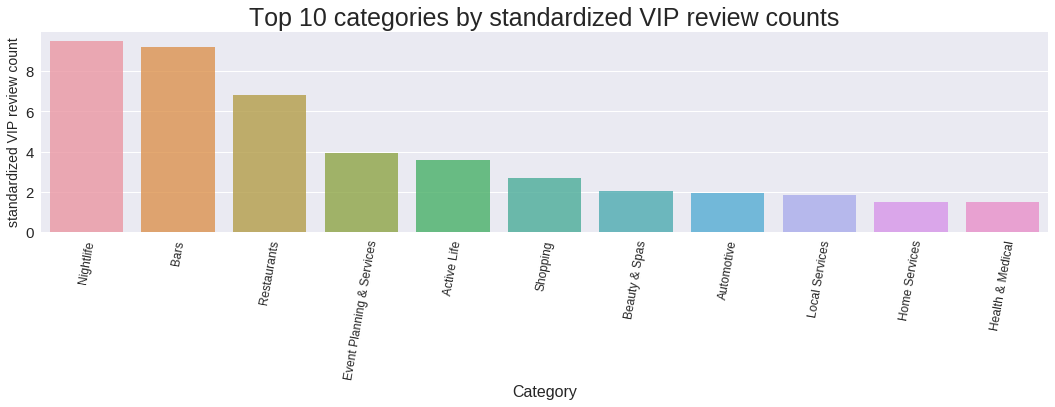

In [35]:

import seaborn as sns 
plt.figure(figsize=(15,6))
ax = sns.barplot(catre.category, catre['review_count_by_VIP%'], alpha=0.8)#,color=color[5])
sns.set(font_scale=1.5)
plt.title("Top 10 categories by standardized VIP review counts",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80, fontsize=12)
plt.ylabel('standardized VIP review count', fontsize=14)
plt.xlabel('Category', fontsize=16)
plt.tight_layout()
plt.savefig('Q2/Top 10 categories by VIP review counts latest version6.jpg', dpi=600)

# #adding the text labels
# rects = ax.patches
# labels = x.values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

# plt.show()